# Pauli Check Extrapolation (PCE) Demonstration

This notebook demonstrates Pauli Check Extrapolation (PCE) for quantum error mitigation using a 4-qubit GHZ state.
**Reference:** https://arxiv.org/abs/2406.14759

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

from quantem.compiler import QEDCompiler
from quantem.pauli_check_extrapolation import analyze_pce_results

## 1. Create Test Circuit (GHZ State)

We'll use a GHZ state: $|\text{GHZ}\rangle = \frac{1}{\sqrt{2}}(|0000\rangle + |1111\rangle)$

For this state, the all-Z observable $\langle Z \otimes Z \otimes Z \otimes Z \rangle = 1.0$ (ideal)

Circuit: 4 qubits, Depth: 4, Gates: 4


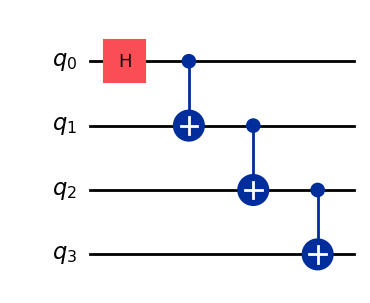

In [2]:
def create_ghz_circuit(num_qubits):
    """Create a GHZ state circuit."""
    circuit = QuantumCircuit(num_qubits)
    circuit.h(0)
    for i in range(num_qubits - 1):
        circuit.cx(i, i + 1)
    return circuit

# Create 4-qubit GHZ circuit
num_data_qubits = 4
circuit = create_ghz_circuit(num_data_qubits)

print(f"Circuit: {num_data_qubits} qubits, Depth: {circuit.depth()}, Gates: {len(circuit.data)}")
circuit.draw('mpl')

## 2. Compile with PCE

Compile the circuit with multiple check counts for PCE.
- `only_Z_checks=True`: Only use Z-type Pauli checks
- `check_counts=[1, 2, 3, 4]`: Compile with 1, 2, 3, and 4 checks
- **Note**: 4 checks is the maximum needed for full protection of a 4-qubit circuit

In [3]:
compiler = QEDCompiler(verbose=True)
check_counts = [1, 2, 3, 4]  # Include 4 checks (maximum for 4-qubit circuit)

# Compile for PCE with only Z checks
pce_result = compiler.compile_pce(
    circuit, 
    check_counts=check_counts, 
    only_Z_checks=True
)

print("\n" + "="*60)
print("PCE Compilation Complete")
print("="*60)
print(f"Compiled {len(pce_result.circuits)} circuits with check counts: {sorted(pce_result.circuits.keys())}")
print(f"Strategy used: {pce_result.strategy_used.value.upper()}")
print(f"\nNote: 4 checks is the maximum for full protection of a {num_data_qubits}-qubit circuit")

[quantem.compiler] INFO: Compiling circuit for PCE with 4 check counts: [1, 2, 3, 4]
[quantem.compiler] INFO: Compiling with 1 checks
[quantem.compiler] INFO: Compiling with 2 checks
[quantem.compiler] INFO: Compiling with 3 checks
[quantem.compiler] INFO: Compiling with 4 checks
[quantem.compiler] INFO: PCE compilation complete for 4 circuits


Found check 1: +1IIIX, +1IIIZ
Required number of checks found.
p1_list =  [['+1IIIX', '+1IIIZ']]
Found check 1: +1IIIX, +1IIIZ
Found check 2: +1IIZX, +1IIZI
Required number of checks found.
p1_list =  [['+1IIIX', '+1IIIZ'], ['+1IIZX', '+1IIZI']]
Found check 1: +1IIIX, +1IIIZ
Found check 2: +1IIZX, +1IIZI
Found check 3: +1IZZX, +1IZII
Required number of checks found.
p1_list =  [['+1IIIX', '+1IIIZ'], ['+1IIZX', '+1IIZI'], ['+1IZZX', '+1IZII']]
Found check 1: +1IIIX, +1IIIZ
Found check 2: +1IIZX, +1IIZI
Found check 3: +1IZZX, +1IZII
Found check 4: +1ZZZX, +1ZIII
Required number of checks found.
p1_list =  [['+1IIIX', '+1IIIZ'], ['+1IIZX', '+1IIZI'], ['+1IZZX', '+1IZII'], ['+1ZZZX', '+1ZIII']]

PCE Compilation Complete
Compiled 4 circuits with check counts: [1, 2, 3, 4]
Strategy used: PCS

Note: 4 checks is the maximum for full protection of a 4-qubit circuit


## 3. Inspect Compiled Circuits

Let's examine one of the compiled circuits to see the ancilla qubits and check structure.

Circuit with 2 checks:
Total qubits: 6
Data qubits: 4
Ancilla qubits: 2
Check signs: ['+1', '+1']

Circuit depth: 13


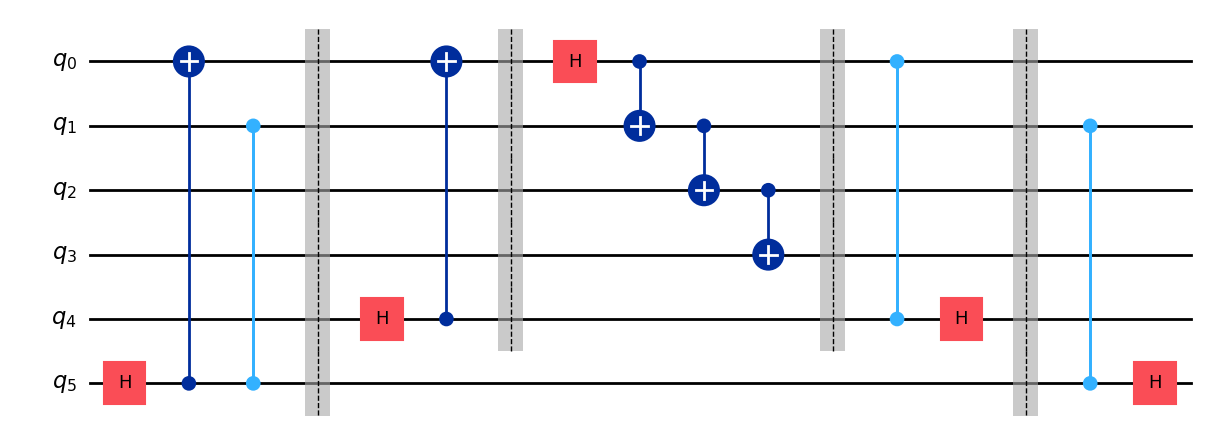

In [4]:
# Inspect circuit with 2 checks
n_inspect = 2
print(f"Circuit with {n_inspect} checks:")
print(f"Total qubits: {pce_result.circuits[n_inspect].num_qubits}")
print(f"Data qubits: {num_data_qubits}")
print(f"Ancilla qubits: {pce_result.circuits[n_inspect].num_qubits - num_data_qubits}")
print(f"Check signs: {pce_result.metadata[n_inspect]['sign_list']}")
print(f"\nCircuit depth: {pce_result.circuits[n_inspect].depth()}")

pce_result.circuits[n_inspect].draw('mpl')

## 4. Set Up Noise Model

**Sanity Check Configuration:**
- Apply depolarizing noise to **data gates only** (H, CX)
- **No noise** on ancilla measurements or check operations
- This validates that PCE works correctly in the ideal case

In [5]:
def create_data_only_noise_model(p_1q=0.01, p_2q=0.05, num_data_qubits=4):
    """
    Create a noise model that only affects data qubits.
    
    Args:
        p_1q: Single-qubit depolarizing error rate
        p_2q: Two-qubit depolarizing error rate
        num_data_qubits: Number of data qubits (ancillas are noiseless)
    """
    noise_model = NoiseModel()
    
    # Define errors
    error_1q = depolarizing_error(p_1q, 1)
    error_2q = depolarizing_error(p_2q, 2)
    
    # Apply only to data qubits (qubits 0 to num_data_qubits-1)
    data_qubits = list(range(num_data_qubits))
    
    # Add noise to single-qubit gates on each data qubit individually
    for q in data_qubits:
        noise_model.add_quantum_error(error_1q, ['h', 's', 'sdg', 'x', 'y', 'z'], [q])
    
    # Add noise to two-qubit gates (only when both qubits are data qubits)
    for q1 in data_qubits:
        for q2 in data_qubits:
            if q1 != q2:
                noise_model.add_quantum_error(error_2q, ['cx', 'cz'], [q1, q2])
    
    return noise_model

# Create noise model
p_1q = 0.02  # 2% single-qubit error rate
p_2q = 0.10  # 10% two-qubit error rate

noise_model = create_data_only_noise_model(p_1q=p_1q, p_2q=p_2q, num_data_qubits=num_data_qubits)
backend = AerSimulator(noise_model=noise_model)

print(f"Noise Model Configuration:")
print(f"  Single-qubit error rate (data qubits only): {p_1q*100}%")
print(f"  Two-qubit error rate (data qubits only): {p_2q*100}%")
print(f"  Ancilla qubits: NOISELESS (for sanity check)")

Noise Model Configuration:
  Single-qubit error rate (data qubits only): 2.0%
  Two-qubit error rate (data qubits only): 10.0%
  Ancilla qubits: NOISELESS (for sanity check)


## 5. Run Simulations

Execute all compiled circuits and the baseline circuit, measuring the all-Z observable.

In [6]:
def calculate_all_z_observable(counts, num_data_qubits, total_qubits):
    """
    Calculate <Z⊗Z⊗...⊗Z> observable with post-selection on ancillas.
    
    Args:
        counts: Measurement counts from Qiskit
        num_data_qubits: Number of data qubits
        total_qubits: Total number of qubits (data + ancilla)
    
    Returns:
        (expectation_value, post_selection_rate)
    """
    # Ancilla qubits are [num_data_qubits, ..., total_qubits-1]
    ancilla_indices = list(range(num_data_qubits, total_qubits))
    
    total_postselected = 0
    expectation_sum = 0
    
    for bitstring, count in counts.items():
        # Check if all ancillas measured 0 (no error detected)
        pass_checks = True
        for q_idx in ancilla_indices:
            # Qiskit bitstring: rightmost bit is qubit 0
            bit_idx = len(bitstring) - 1 - q_idx
            if bitstring[bit_idx] == '1':
                pass_checks = False
                break
        
        if pass_checks:
            total_postselected += count
            
            # Calculate parity of data qubits for Z⊗Z⊗...⊗Z
            # Even parity -> +1, Odd parity -> -1
            data_parity = 0
            for q_idx in range(num_data_qubits):
                bit_idx = len(bitstring) - 1 - q_idx
                if bitstring[bit_idx] == '1':
                    data_parity += 1
            
            observable_value = -1 if (data_parity % 2 == 1) else 1
            expectation_sum += observable_value * count
    
    if total_postselected == 0:
        return 0.0, 0.0
    
    expectation = expectation_sum / total_postselected
    post_selection_rate = total_postselected / sum(counts.values())
    
    return expectation, post_selection_rate

In [7]:
shots = 10000
expectations = {}

print("Running simulations...\n")
print(f"{'Check Count':<12} {'Expectation':<15} {'Post-Selection Rate':<20}")
print("="*50)

# Run PCE circuits
for n in sorted(check_counts):
    qc = pce_result.circuits[n].copy()
    qc.measure_all()
    
    # Transpile and run
    t_qc = transpile(qc, backend)
    result = backend.run(t_qc, shots=shots).result()
    counts = result.get_counts()
    
    # Calculate observable
    total_qubits = qc.num_qubits
    exp_val, post_sel_rate = calculate_all_z_observable(counts, num_data_qubits, total_qubits)
    
    expectations[n] = exp_val
    print(f"n={n:<10} {exp_val:<15.6f} {post_sel_rate:<20.1%}")

# Run baseline (no checks)
print("\n" + "-"*50)
qc_baseline = circuit.copy()
qc_baseline.measure_all()
t_qc_baseline = transpile(qc_baseline, backend)
result_baseline = backend.run(t_qc_baseline, shots=shots).result()
counts_baseline = result_baseline.get_counts()

baseline_exp, _ = calculate_all_z_observable(counts_baseline, num_data_qubits, num_data_qubits)
print(f"Baseline:    {baseline_exp:<15.6f} (no post-selection)")
print("="*50)

Running simulations...

Check Count  Expectation     Post-Selection Rate 
n=1          0.756280        93.5%               
n=2          0.892747        87.3%               
n=3          0.947323        80.9%               
n=4          1.000000        78.0%               

--------------------------------------------------
Baseline:    0.729000        (no post-selection)


## 6. Perform PCE Extrapolation

Extrapolate the expectation values to n=4 (the maximum checks for full protection).

Since we're using noiseless checks, the n=4 measurement should already be nearly perfect.

In [8]:
# Extrapolate to n_max=4 (the maximum checks needed for full protection)
n_max = 4  # 4 checks fully protects a 4-qubit circuit

pce_analysis = analyze_pce_results(expectations, n_max=n_max, model="exponential")
extrapolated_value = pce_analysis['extrapolated_value']

print("\n" + "="*60)
print("PCE RESULTS")
print("="*60)
print(f"Ideal value (theory):        1.000000")
print(f"Baseline (no checks):        {baseline_exp:.6f}")
print(f"Measured (n=4):              {expectations[4]:.6f}")
print(f"Extrapolated (n→{n_max}):       {extrapolated_value:.6f}")

# Calculate error reduction
baseline_error = abs(1.0 - baseline_exp)
n4_error = abs(1.0 - expectations[4])
pce_error = abs(1.0 - extrapolated_value)
improvement_vs_baseline = (1 - pce_error / baseline_error) * 100 if baseline_error > 0 else 0

print(f"\nBaseline error:              {baseline_error:.6f}")
print(f"n=4 error:                   {n4_error:.6f}")
print(f"PCE error:                   {pce_error:.6f}")
print(f"Error reduction vs baseline: {improvement_vs_baseline:.1f}%")
print("="*60)
print("\n** Since checks are noiseless, n=4 should give near-perfect results **")


PCE RESULTS
Ideal value (theory):        1.000000
Baseline (no checks):        0.729000
Measured (n=4):              1.000000
Extrapolated (n→4):       0.999066

Baseline error:              0.271000
n=4 error:                   0.000000
PCE error:                   0.000934
Error reduction vs baseline: 99.7%

** Since checks are noiseless, n=4 should give near-perfect results **


## 7. Visualize Results

Plot the expectation values vs. check count with the fitted extrapolation curve.

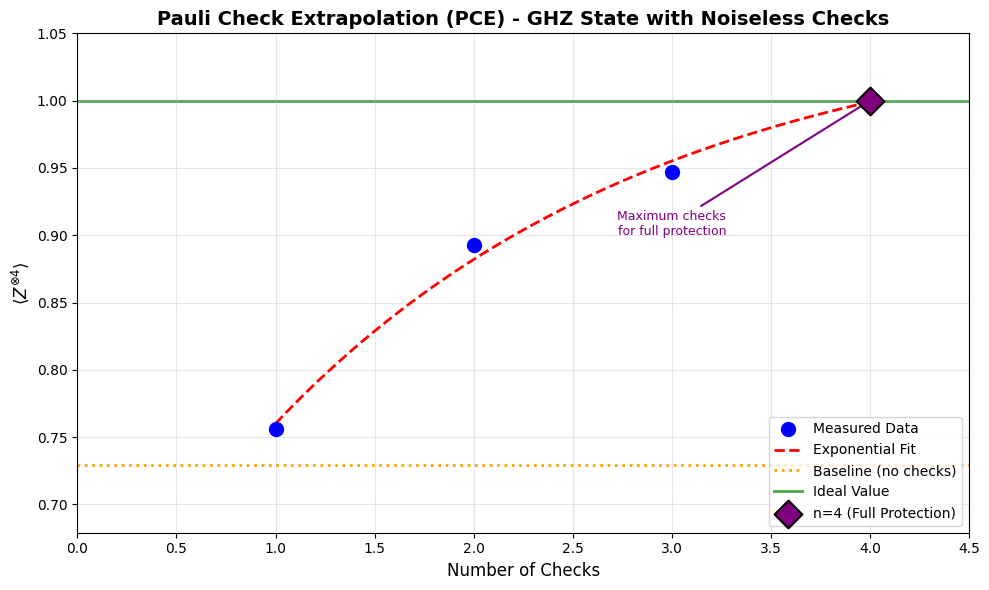

In [9]:
# Prepare data for plotting
x = sorted(expectations.keys())
y = [expectations[k] for k in x]

# Generate fitted curve
x_fit = np.linspace(min(x), n_max, 100)
params = pce_analysis['params']
y_fit = params['a'] * (params['b'] ** x_fit) + params['c']

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', markersize=10, label='Measured Data', zorder=3)
plt.plot(x_fit, y_fit, 'r--', linewidth=2, label=f'Exponential Fit', zorder=2)
plt.axhline(baseline_exp, color='orange', linestyle=':', linewidth=2, label='Baseline (no checks)', zorder=1)
plt.axhline(1.0, color='green', linestyle='-', linewidth=2, alpha=0.7, label='Ideal Value', zorder=1)

# Highlight the n=4 point
plt.scatter([4], [expectations[4]], color='purple', s=200, marker='D', 
            label='n=4 (Full Protection)', zorder=4, edgecolors='black', linewidths=1.5)

plt.xlabel('Number of Checks', fontsize=12)
plt.ylabel(r'$\langle Z^{\otimes 4} \rangle$', fontsize=12)
plt.title('Pauli Check Extrapolation (PCE) - GHZ State with Noiseless Checks', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim(0, n_max + 0.5)
plt.ylim(min(y + [baseline_exp]) - 0.05, 1.05)

# Add annotation for n=4
plt.annotate('Maximum checks\nfor full protection', 
             xy=(4, expectations[4]), xytext=(3, expectations[4] - 0.1),
             arrowprops=dict(arrowstyle='->', color='purple', lw=1.5),
             fontsize=9, color='purple', ha='center')

plt.tight_layout()
plt.show()